# Michaelis-Menten Model Calibration Example

In [41]:
import numpy as np
import roadrunner
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import copy

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import os 

SEED=123456
np.random.seed(seed=SEED)
engine = eng.MultiProcessEngine(n_procs=os.cpu_count())

print(os.cpu_count())

MODEL_SBML_FILE = "model_sbml.xml"
SPECIES = ["S", "E", "ES", "P"]
SPECIES_IDs = ["S1", "S2", "S3", "S4"] # how the species ids are saved in the SBML file from the original BNGL model
SPECIES_COLORS = ["r", "b", "indigo", "g"]
PARAMS = ["log_k1", "log_k2", "log_k3"]

LOG_ERROR = False

8


### Load experimental data used to calibrate model
From here: https://github.com/RuleWorld/ptempest/tree/master/examples/michment

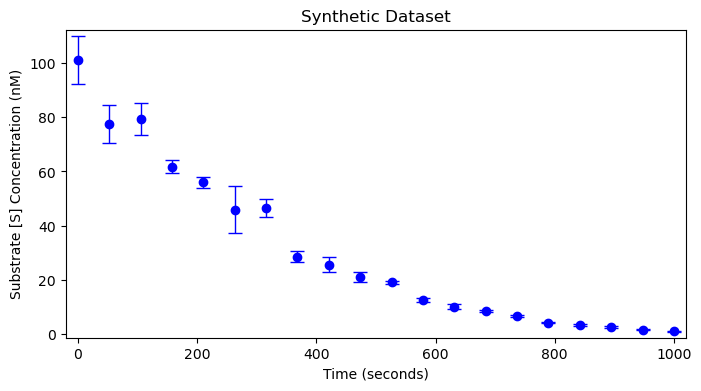

In [42]:
data = io.loadmat("MM.mat")["expt"]
data = data.ravel()[0][0]
data_ts = data["time"][0].flatten()
means = data["mean"][0]
data_means = means[~(pd.isnull(means))]
stds = data["stdev"][0]
data_stds = stds[~(pd.isnull(stds))]
labels = data["obsv_labels"][0][0]
data_labels = [x[0] for x in labels]
init_conds = [data["S0"][0][0][0], data["E0"][0][0][0]]

plt.figure(figsize=(8,4)),
plt.errorbar(data_ts, data_means, yerr=data_stds, capsize=5, c="b", lw=0, marker="o", elinewidth=1);
plt.xlabel("Time (seconds)"); plt.ylabel("Substrate [S] Concentration (nM)");
plt.margins(x=0.02, y=0.02);
plt.title("Synthetic Dataset");

### Load model using `libroadrunner`

In [43]:
rr = roadrunner.RoadRunner(MODEL_SBML_FILE)
rr.integrator.absolute_tolerance = 5e-10
rr.integrator.relative_tolerance = 1e-8
print(rr.model.getGlobalParameterIds())
rr["init([S1])"] = float(init_conds[0]) # change initial substrate concentration
rr["init([S2])"] = float(init_conds[1]) # change initial enzyme concentration

['log_k1', 'log_k2', 'log_k3', 'S', 'E', 'ES', 'P', 'k1', 'k2', 'k3']


### Define helper functions that change model parameters and simulate model

log_k1 PRE-CHANGE IN MODEL:  -4.6052
log_k1 -10 -10.0
log_k2 PRE-CHANGE IN MODEL:  0.0
log_k2 -10 -10.0
log_k3 PRE-CHANGE IN MODEL:  0.0
log_k3 -10 -10.0


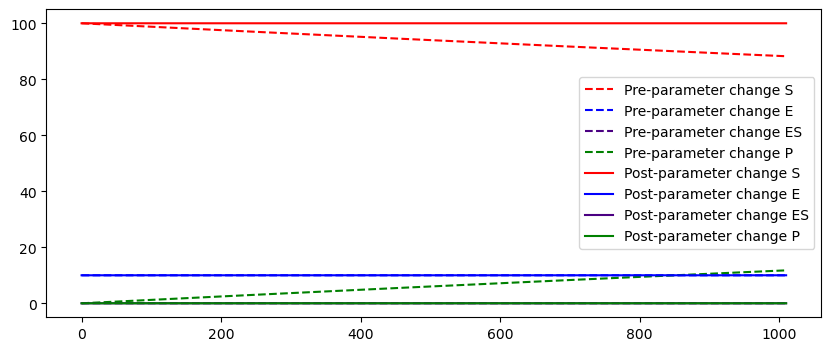

In [44]:
def change_and_run(new_params):
    rr.reset()
    for name,val in zip(PARAMS, new_params):
        print(name, "PRE-CHANGE IN MODEL: ",  rr[name])
        rr[name] = val
        rr.reset() # This forces assignment rules in the SBML model to be re-evaluated
        print(name, val, rr[name])
    try:
        res = rr.simulate(0, 1010, 10101)
        #print(res)
    except:
        res = []
    return res

rr.resetAll()
plt.figure(figsize=(10,4))
orig_traj = rr.simulate(0,1010,10101)
orig_ts = orig_traj[:, 0]
orig_specs = np.transpose(orig_traj[:, 1:])
for cur_label, cur_traj, cur_c in zip(SPECIES, orig_specs, SPECIES_COLORS):
    plt.plot(orig_ts, cur_traj, c=cur_c, label="Pre-parameter change %s"%cur_label, linestyle="--")
plt.legend();

# sanity check by setting all parameters to near 0
traj = change_and_run([-10, -10, -10])
traj_ts = traj[:, 0]
traj_specs = np.transpose(traj[:, 1:])

for cur_label, cur_traj, cur_c in zip(SPECIES, traj_specs, SPECIES_COLORS):
    plt.plot(traj_ts, cur_traj, c=cur_c, label="Post-parameter change %s"%cur_label)
plt.legend();


### Define cost function

In [45]:
def cost_fun(params):
    candidate_params = copy.deepcopy(params)    
    guess_res = change_and_run(candidate_params)

    if np.isnan(guess_res).any():
        return np.inf
    
    guess_ts = guess_res[:, 0]
    guess_s = guess_res[:, 1] # substrate 
    print(guess_ts)
    print('Data: ', data_ts)
    t_idxs = np.where(np.isin(guess_ts, data_ts))[0]
    print('\n\n', t_idxs)
    if t_idxs.shape[0] != data_ts.shape[0]:
        raise Exception('Not all the times outputted by candidate parameter system are found in data time points! We cannot calculate error!')
    
    guess_s_short = guess_s[guess_ts]
    sse = np.sum(np.square(data_means - guess_s_short) / data_stds)
    
    if LOG_ERROR:
        sse = np.log10(sse)
        
    return sse
    

cost_fun([-1,-1,-1])

log_k1 PRE-CHANGE IN MODEL:  -10.0
log_k1 -1 -1.0
log_k2 PRE-CHANGE IN MODEL:  -10.0
log_k2 -1 -1.0
log_k3 PRE-CHANGE IN MODEL:  -10.0
log_k3 -1 -1.0
[0.0000e+00 1.0000e-01 2.0000e-01 ... 1.0098e+03 1.0099e+03 1.0100e+03]
Data:  [   0.           52.63157895  105.26315789  157.89473684  210.52631579
  263.15789474  315.78947368  368.42105263  421.05263158  473.68421053
  526.31578947  578.94736842  631.57894737  684.21052632  736.84210526
  789.47368421  842.10526316  894.73684211  947.36842105 1000.        ]


 [    0 10000]


Exception: Not all the times outputted by candidate parameter system are found in data time points! We cannot calculate error!